# Lenet5 Example

<!-- TOC -->

- [Lenet5 for Beginners](#quick-start-for-beginners)
    - [The Architecture of Lenet5](#the-architecture-of-lenet5)
    - [The Implementation of LeNet5](#imple-lenet5)
     - [Configuring the Running Information](#configuring-the-running-information)
     - [Downloading the Dataset](#downloading-the-dataset)
     - [Data Processing](#data-processing)
     - [Creating a Model](#creating-a-model)
     - [Optimizing Model Parameters](#optimizing-model-parameters)
     - [Training and Saving the Model](#training-and-saving-the-model)
     - [Loading the Model](#loading-the-model)
     - [Validating the Model](#validating-the-model)
    - [Some exercises](#exercise)

<!-- /TOC -->

## The Architecture of Lenet5

![Lenet5](images/lenet5.jpeg)

The LeNet-5 architecture consists of two sets of convolutional and average pooling layers, followed by a flattening convolutional layer, then two fully-connected layers and finally a softmax classifier.

C1 Layer:

![1](images/1.jpeg)

S2 Layer:

![2](images/2.jpeg)

C3 Layer:

![3](images/3_2.jpeg)

S4 Layer:

![4](images/4.jpeg)

C5 Layer:

![5](images/5.jpeg)

S6 Layer:

![6](images/6.jpeg)

Output Layer:

![7](images/7.jpeg)

Summary:

![8](images/summary.jpeg)

## The Implementation of LeNet5

### Configuring the Running Information

MindSpore uses `context.set_context` to configure the information required for running, such as the running mode, backend information, and hardware information.

Import the `context` module and configure the required information.

In [1]:
import os
import argparse
from mindspore import context

parser = argparse.ArgumentParser(description='MindSpore LeNet Example')
parser.add_argument('--device_target', type=str, default="Ascend", choices=['Ascend', 'GPU', 'CPU'])

args = parser.parse_known_args()[0]
context.set_context(mode=context.GRAPH_MODE, device_target=args.device_target)

This example runs in graph mode. You can configure hardware information as required. For example, if the code runs on the Ascend AI processor, set `--device_target` to `Ascend`. This rule also applies to the code running on the CPU and GPU. For details about the parameters, see [context.set_context](https://www.mindspore.cn/doc/api_python/en/r1.2/mindspore/mindspore.context.html).

### Downloading the Dataset

The MNIST dataset used in this example consists of 10 classes of 28 x 28 pixels grayscale images. It has a training set of 60,000 examples, and a test set of 10,000 examples.

Click [here](http://yann.lecun.com/exdb/mnist/) to download the MNIST dataset and place the dataset according to the following directory structure. 

```text
    ./datasets/MNIST_Data
    ├── test
    │   ├── t10k-images-idx3-ubyte
    │   └── t10k-labels-idx1-ubyte
    └── train
        ├── train-images-idx3-ubyte
        └── train-labels-idx1-ubyte

    2 directories, 4 files
```

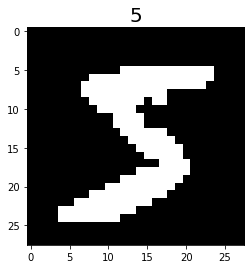

In [2]:
import matplotlib.pyplot as plt
import mindspore.dataset as ds

DATA_DIR_TEST = './datasets/MNIST_Data/train'

mnist_dataset_test = ds.MnistDataset(DATA_DIR_TEST, num_samples=6, shuffle=False)

# View the original image data.
mnist_it_test = mnist_dataset_test.create_dict_iterator()
data = next(mnist_it_test)
plt.imshow(data['image'].asnumpy().squeeze(), cmap=plt.cm.gray)
plt.title(data['label'].asnumpy(), fontsize=20)
plt.show()

### Data Processing

Datasets are crucial for model training. A good dataset can effectively improve training accuracy and efficiency.
MindSpore provides the API module `mindspore.dataset` for data processing to store samples and labels. Before loading a dataset, we usually process the dataset. `mindspore.dataset` integrates common data processing methods.

Import `mindspore.dataset` and other corresponding modules in MindSpore.

In [3]:
import mindspore.dataset as ds
import mindspore.dataset.transforms.c_transforms as C
import mindspore.dataset.vision.c_transforms as CV
from mindspore.dataset.vision import Inter
from mindspore import dtype as mstype

Dataset processing consists of the following steps:

1. Define the `create_dataset` function to create a dataset.
2. Define the data augmentation and processing operations to prepare for subsequent mapping.
3. Use the map function to apply data operations to the dataset.
4. Perform shuffle and batch operations on data.

In [4]:
def create_dataset(data_path, batch_size=32, num_parallel_workers=1):
    # Define the dataset.
    mnist_ds = ds.MnistDataset(data_path)
    resize_height, resize_width = 32, 32
    rescale = 1.0 / 255.0
    shift = 0.0
    rescale_nml = 1 / 0.3081
    shift_nml = -1 * 0.1307 / 0.3081

    # Define the mapping to be operated.
    resize_op = CV.Resize((resize_height, resize_width), interpolation=Inter.LINEAR)
    rescale_nml_op = CV.Rescale(rescale_nml, shift_nml)
    rescale_op = CV.Rescale(rescale, shift)
    hwc2chw_op = CV.HWC2CHW()
    type_cast_op = C.TypeCast(mstype.int32)

    # Use the map function to apply data operations to the dataset.
    mnist_ds = mnist_ds.map(operations=type_cast_op, input_columns="label", num_parallel_workers=num_parallel_workers)
    mnist_ds = mnist_ds.map(operations=resize_op, input_columns="image", num_parallel_workers=num_parallel_workers)
    mnist_ds = mnist_ds.map(operations=rescale_op, input_columns="image", num_parallel_workers=num_parallel_workers)
    mnist_ds = mnist_ds.map(operations=rescale_nml_op, input_columns="image", num_parallel_workers=num_parallel_workers)
    mnist_ds = mnist_ds.map(operations=hwc2chw_op, input_columns="image", num_parallel_workers=num_parallel_workers)

    # Perform shuffle and batch operations.
    buffer_size = 10000
    mnist_ds = mnist_ds.shuffle(buffer_size=buffer_size)
    mnist_ds = mnist_ds.batch(batch_size, drop_remainder=True)

    return mnist_ds

In the preceding information, `batch_size` indicates the number of data records in each group. Assume that each group contains 32 data records.

> MindSpore supports multiple data processing and argumentation operations. For details, see [Processing Data](https://www.mindspore.cn/doc/programming_guide/en/r1.2/pipeline.html) and [Data Augmentation](https://www.mindspore.cn/doc/programming_guide/en/r1.2/augmentation.html).

### Creating a Model

To use MindSpore for neural network definition, inherit `mindspore.nn.Cell`. `Cell` is the base class of all neural networks (such as `Conv2d-relu-softmax`).

Define each layer of a neural network in the `__init__` method in advance, and then define the `construct` method to complete the forward construction of the neural network. According to the LeNet structure, define the network layers as follows:

In [5]:
import mindspore.nn as nn
from mindspore.common.initializer import Normal

class LeNet5(nn.Cell):
    """
    Lenet network structure
    """
    def __init__(self, num_class=10, num_channel=1):
        super(LeNet5, self).__init__()
        # Define the required operation.
        self.conv1 = nn.Conv2d(num_channel, 6, 5, pad_mode='valid')
        self.conv2 = nn.Conv2d(6, 16, 5, pad_mode='valid')
        self.fc1 = nn.Dense(16 * 5 * 5, 120, weight_init=Normal(0.02))
        self.fc2 = nn.Dense(120, 84, weight_init=Normal(0.02))
        self.fc3 = nn.Dense(84, num_class, weight_init=Normal(0.02))
        self.relu = nn.ReLU()
        self.max_pool2d = nn.MaxPool2d(kernel_size=2, stride=2)
        self.flatten = nn.Flatten()

    def construct(self, x):
        # Use the defined operation to construct a forward network.
        x = self.conv1(x)
        x = self.relu(x)
        x = self.max_pool2d(x)
        x = self.conv2(x)
        x = self.relu(x)
        x = self.max_pool2d(x)
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.relu(x)
        x = self.fc3(x)
        return x

# Instantiate the network.
net = LeNet5()

> For more information about building a neural network in MindSpore, see [Defining the Network](https://www.mindspore.cn/tutorial/training/en/r1.2/use/defining_the_network.html).

### Optimizing Model Parameters

To train a neural network model, a loss function and an optimizer need to be defined.

Loss functions supported by MindSpore include `SoftmaxCrossEntropyWithLogits`, `L1Loss`, and `MSELoss`. The following uses the cross-entropy loss function `SoftmaxCrossEntropyWithLogits`.


In [6]:
# Define the loss function.
net_loss = nn.SoftmaxCrossEntropyWithLogits(sparse=True, reduction='mean')

> For more information about using loss functions in MindSpore, see [Loss Functions](https://www.mindspore.cn/tutorial/en/r1.2/optimization.html#loss-functions).

MindSpore supports the `Adam`, `AdamWeightDecay`, and `Momentum` optimizers. The following uses the `Momentum` optimizer as an example.

In [7]:
# Define the optimizer.
net_opt = nn.Momentum(net.trainable_params(), learning_rate=0.1, momentum=0.9)

> For more information about using an optimizer in MindSpore, see [Optimizer](https://www.mindspore.cn/tutorial/en/r1.2/optimization.html#optimizer).

### Training and Saving the Model

MindSpore provides the callback mechanism to execute custom logic during training. The following uses `ModelCheckpoint` provided by the framework as an example.
`ModelCheckpoint` can save the network model and parameters for subsequent fine-tuning.

In [8]:
from mindspore.train.callback import ModelCheckpoint, CheckpointConfig
# Set model saving parameters.
config_ck = CheckpointConfig(save_checkpoint_steps=1875, keep_checkpoint_max=10)
# Use model saving parameters.
ckpoint = ModelCheckpoint(prefix="checkpoint_lenet", config=config_ck)

The `model.train` API provided by MindSpore can be used to easily train the network. `LossMonitor` can monitor the changes of the `loss` value during the training process.

In [9]:
# Import the library required for model training.
from mindspore.nn import Accuracy
from mindspore.train.callback import LossMonitor
from mindspore import Model

def train_net(args, model, epoch_size, data_path, ckpoint_cb, sink_mode):
    """Define a training method."""
    # Load the training dataset.
    ds_train = create_dataset(os.path.join(data_path, "train"), 32)
    model.train(epoch_size, ds_train, callbacks=[ckpoint_cb, LossMonitor(125)], dataset_sink_mode=sink_mode)

`dataset_sink_mode` is used to control whether data is offloaded. Data offloading means that data is directly transmitted to the device through a channel to accelerate the training speed. If `dataset_sink_mode` is True, data is offloaded. Otherwise, data is not offloaded.

Validate the generalization capability of the model based on the result obtained by running the test dataset.

1. Read the test dataset using the `model.eval` API.
2. Use the saved model parameters for inference.

In [10]:
def test_net(network, model, data_path):
    """Define a validation method."""
    ds_eval = create_dataset(os.path.join(data_path, "test"))
    acc = model.eval(ds_eval, dataset_sink_mode=False)
    print("{}".format(acc))

Set `train_epoch` to 1 to train the dataset in one epoch. In the `train_net` and `test_net` methods, the previously downloaded training dataset is loaded. `mnist_path` is the path of the MNIST dataset.

In [11]:
train_epoch = 1
mnist_path = "./datasets/MNIST_Data"
model = Model(net, net_loss, net_opt, metrics={"Accuracy": Accuracy()})
train_net(args, model, train_epoch, mnist_path, ckpoint, False)
test_net(net, model, mnist_path)

epoch: 1 step: 125, loss is 2.2873926
epoch: 1 step: 250, loss is 1.5333253
epoch: 1 step: 375, loss is 0.9400614
epoch: 1 step: 500, loss is 1.3846397
epoch: 1 step: 625, loss is 1.502626
epoch: 1 step: 750, loss is 2.0026922
epoch: 1 step: 875, loss is 2.2878313
epoch: 1 step: 1000, loss is 2.1573153
epoch: 1 step: 1125, loss is 1.9357469
epoch: 1 step: 1250, loss is 2.2365723
epoch: 1 step: 1375, loss is 2.0302742
epoch: 1 step: 1500, loss is 2.0191965
epoch: 1 step: 1625, loss is 1.9911989
epoch: 1 step: 1750, loss is 2.127056
epoch: 1 step: 1875, loss is 1.8617754
{'Accuracy': 0.19621394230769232}


Run the following command to execute the script:

```bash
python lenet.py --device_target=Ascend
```

Where,

`lenet.py`: You can paste the preceding code to lenet.py (excluding the code for downloading the dataset). Generally, you can move the import part to the beginning of the code, place the definitions of classes, functions, and methods after the code, and connect the preceding operations in the main method.

`--device_target=CPU`: specifies the running hardware platform. The parameter value can be `CPU`, `GPU`, or `Ascend`, depending on the actual running hardware platform.

Loss values are displayed during training, as shown in the following. Although loss values may fluctuate, they gradually decrease and the accuracy gradually increases in general. Loss values displayed each time may be different because of their randomicity.
The following is an example of loss values output during training:

```text
epoch: 1 step: 125, loss is 2.3083377
epoch: 1 step: 250, loss is 2.3019726
...
epoch: 1 step: 1500, loss is 0.028385757
epoch: 1 step: 1625, loss is 0.0857362
epoch: 1 step: 1750, loss is 0.05639569
epoch: 1 step: 1875, loss is 0.12366105
{'Accuracy': 0.9663477564102564}
```

The model accuracy data is displayed in the output content. In the example, the accuracy reaches 96.6%, indicating a good model quality. As the number of network epochs (`train_epoch`) increases, the model accuracy will be further improved.

### Loading the Model

In [12]:
from mindspore.train.serialization import load_checkpoint, load_param_into_net
# Load the saved model for testing.
param_dict = load_checkpoint("checkpoint_lenet-1_1875.ckpt")
# Load parameters to the network.
load_param_into_net(net, param_dict)

[]

> For more information about loading a model in MindSpore, see [Loading the Model](https://www.mindspore.cn/tutorial/en/r1.2/save_load_model.html#loading-the-model).

### Validating the Model

Use the generated model to predict the classification of a single image. The procedure is as follows:

In [13]:
import numpy as np
from mindspore import Tensor

# Define a test dataset. If batch_size is set to 1, an image is obtained.
ds_test = create_dataset(os.path.join(mnist_path, "test"), batch_size=1).create_dict_iterator()
data = next(ds_test)

# `images` indicates the test image, and `labels` indicates the actual classification of the test image.
images = data["image"].asnumpy()
labels = data["label"].asnumpy()

# Use the model.predict function to predict the classification of the image.
output = model.predict(Tensor(data['image']))
predicted = np.argmax(output.asnumpy(), axis=1)

# Output the predicted classification and the actual classification.
print(f'Predicted: "{predicted[0]}", Actual: "{labels[0]}"')

Predicted: "9", Actual: "3"


In [ ]:
import os
pid = os.getpid()
!kill -9 $pid

## Some exercise


1. write your own lenet5 program

2. imporv the accuracy via changing the learning rate from 0.1 to 0.01

net_opt = nn.Momentum(net.trainable_params(), learning_rate=0.1, momentum=0.9)